# kNN & Clustering

__Суммарное количество баллов: 10__

## kNN и рак (3 балла)

В этом части домашнего задания Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas as pd
from sklearn.model_selection import train_test_split as tr
from sklearn.neighbors import KDTree
import scipy.stats as sts
from collections import Counter

### 1. Данные (0.5 балла)


Реализуйте метод `read_cancer_dataset` . Он принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`.

In [2]:
CANCER_DATA_PATH = "C:/Users/лиза/Desktop/учеба/BI/ml/cancer.csv"

In [3]:
def read_cancer_dataset(path_to_csv):
    df = pd.read_csv(path_to_csv)
    X, y = df.drop(columns='label'), df['label']
    y = y.apply(lambda x: 1 if x == 'M' else 0)
    return X, y

In [4]:
X_cancer, y_cancer = read_cancer_dataset(CANCER_DATA_PATH)

Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.7`.

In [5]:
def train_test_split(X, y, ratio):
    # Возвращает X_train, y_train, X_test, y_test
    # X_train и X_test - массив векторов - две части массива X, разделенного в состветсви с коэффициентом ratio
    # y_train и y_test - соответствующие X_train и X_test метки классов
    
    X_train, X_test, y_train, y_test = tr(X, y, train_size = ratio, random_state = 60, shuffle = False)
    return [X_train, y_train, X_test, y_test]

### 2. Метрики (0.5 балла)

Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса. 

__Precision__ отражает то, насколько редко мы ошибаемся, когда говорим, что объект пренадлежит к классу. 

__Recall__ же отражает то, насколько редко классификатор неправильно классифицирует объекты данного класса.

__Accuracy__ отражает то, какую часть выборки классификатор отнес к правильному классу.

In [6]:
def get_precision_recall_accuracy(y_pred, y_true, label = 1):
    # Возвращает precision, recall и accuracy
    # precision - набор значений метрики precision для каждого класса
    # recall - набор значений метрики recall для каждого класса
    # accuracy - число, отражающее общую точность предсказания
    
    tp, tn, fp, fn = 0, 0, 0, 0
    for pred, true in zip(y_pred, y_true):
        if pred == true and pred == label:
            tp += 1
        elif pred == true and pred != label:
            tn += 1
        elif pred != true and pred == label:
            fp += 1
        else:
            fn += 1
    
    precision, recall, accuracy = [tp / (tp + fp), tn / (tn + fn)], [tp / (tp + fn), 
                                                                     tn / (tn + tp)], (tp + tn)/(tp + tn + fp + fn)
    return [precision, recall, accuracy]

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [7]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [8]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c, k in zip(curves_tpr, curves_fpr, colors, ks):
        plt.plot(fpr, tpr, color=c, label = f'k = {k}')
        plt.legend()
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

## 3. KNN (2 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево. (При желании можно воспользоваться библиотечной реализацией дерева)

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток "обучать" классификатор. 

Метод `predict_proba` должен предсказывать вероятности классов для заданного набора данных основываясь на классах соседей

In [9]:
class KNearest:
    def __init__(self, n_neighbors=5, leaf_size=30):
        self.tree = None
        self.n_neighbors = n_neighbors
        self.leaf_size = leaf_size
        self.y = None
        self.data = None   
    
    def fit(self, X, y):
        self.y = y
        self.data = X.index
        self.tree = KDTree(X, leaf_size=self.leaf_size)
        
    def predict_proba(self, X):
        # Возвращает матрицу, в которой строки соответствуют элементам X, а столбцы - классам. 
        # На пересечении строки и столбца должна быть указана вероятность того, что элемент относится к классу
        # Вероятность рассчитывается как количество ближайших соседей 
        # с данным классом деленное на общее количество соседей
        
        dist, idx = self.tree.query(X, k = self.n_neighbors)
        problist = []
        for i in idx:
            prob0 = (self.n_neighbors - sum(self.y[self.data[i]]))/self.n_neighbors
            prob1 = 1 - prob0
            problist.append([prob0, prob1])
        return problist
        
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

Наконец, протестируем наш классификатор на датасете _cancer_

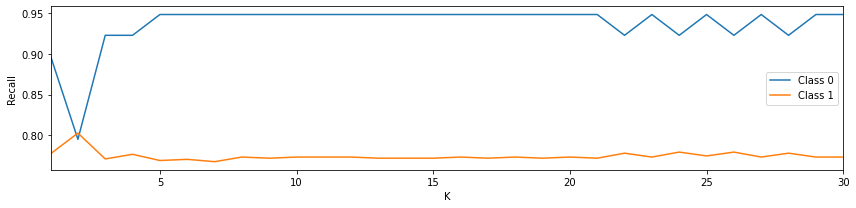

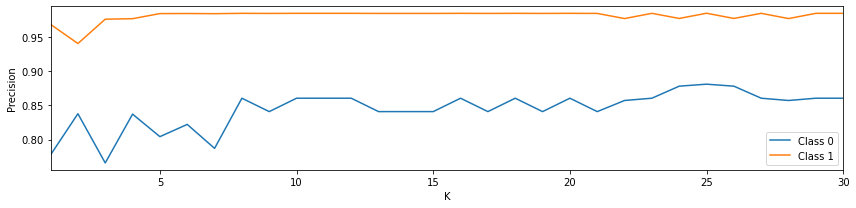

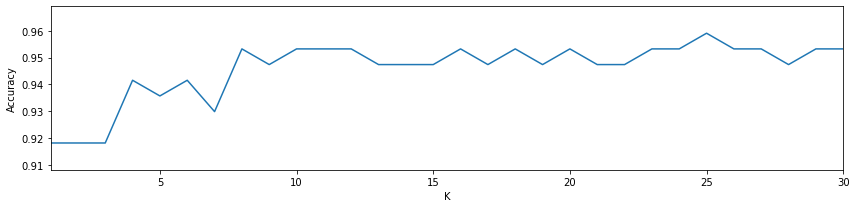

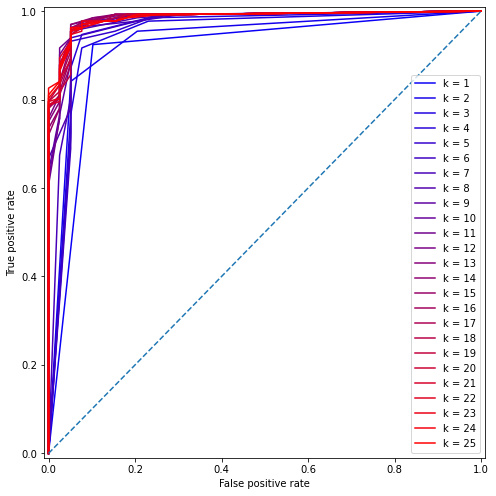

In [10]:
X_train, y_train, X_test, y_test = train_test_split(X_cancer, y_cancer, 0.7)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=25)



Проанализируйте полученные графики. Какой параметр `k` кажется лучшим? Какая из метрик лучше всего отражает качество модели? 

Лучшим кажется параметр k = (12, 15). Поскольку важно не упустить реально больных раком людей, то recall для класса 1 лучше всего отражает качество модели.

## Clustering (7 баллов)

В этой части домашнего задания предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы.

In [11]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
#import cv2
from scipy.spatial import distance
from collections import deque

In [12]:
def visualize_clasters(X, labels, centroids = []):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels) + 100, 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    if len(centroids) > 0:
        plt.scatter(centroids[0], centroids[1], c='black', linewidths = 10, marker = 'o')
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], 
                             [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], 
                             [p[second_color] for p in flatten_image], c=[cluster_colors[c] 
                                                                          for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

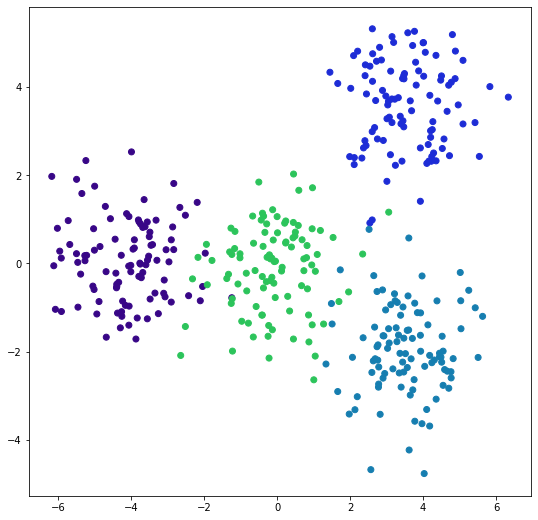

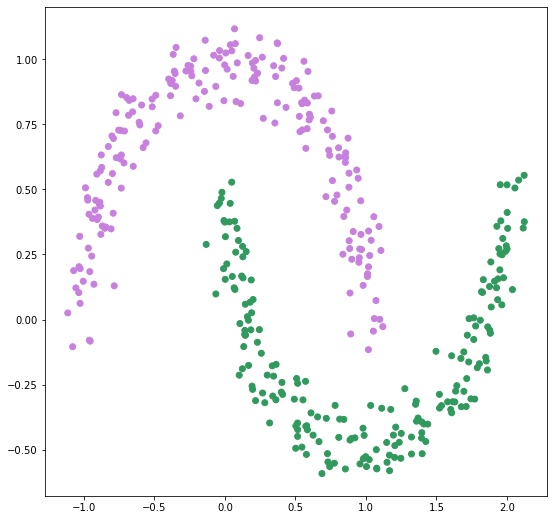

In [13]:
X_1, true_labels1 = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels1)
X_2, true_labels2 = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels2)

### 1. K-means (2.5 балла)

Первый метод, который предлагается реализовать - метод K средних.

__Описание методов__

`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

__Инициализация кластеров__

Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++


In [14]:
class KMeans:
    def __init__(self, n_clusters, init="random", max_iter=100, epsilon = 0.01):
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = []
        self.labels = np.array([])
        self.epsilon = epsilon
        
    def fit(self, X, y=None):
        if self.init == "random":
            conf = [[a.min(), a.max()] for a in X.T]
            
            # для каждого кластера случайно генерируем центроид 
            for i in range(self.n_clusters):
                self.centroids.append([float(sts.uniform.rvs(loc = a, scale = b - a, size = 1)) for a, b in conf])
            self.centroids = np.array(self.centroids)
            
        if self.init == "sample":
            
            # случайно выбираем центроиды из набора данных
            self.centroids = np.array(random.sample(list(X), self.n_clusters))
            
        if self.init == "k-means++":
            
            # выбираем первый центроид случайным образом из всех данных
            self.centroids = np.array(random.sample(list(X), 1))
            
            for n in range(self.n_clusters - 1):
                dist = np.zeros(len(X))
                distc = 0
                
                for i, x in enumerate(X):
                    dist[i] = min([distance.euclidean(x, a) for a in self.centroids])
                    distc += dist[i]
                    
                # случайным образом выбираем центроиды так, чтобы вероятность
                # выбора точки была пропорциональна вычисленному для неё квадрату расстояния
                ncentroid = np.array(random.choices(X, weights = dist / distc))
                self.centroids = np.concatenate((self.centroids, ncentroid))
                
        # создаем метки для каждой точки, вычисляя расстояние до кластеров и ища минимальное
        for x in X:
            targ = np.array([distance.euclidean(x, a) for a in self.centroids]).argmin()
            self.labels = np.append(self.labels, targ)
        
        # далее будем обновлять центроиды
        old_centr = np.copy(self.centroids)
        for this_iter in range(self.max_iter):
            
            for i in range(self.n_clusters):
                id_labels = np.where(self.labels == i)
                if len(id_labels[0]) > 0:
                    self.centroids[i] = sum(X[id_labels]) / len(id_labels[0])

            for i, x in enumerate(X):
                targ = np.array([distance.euclidean(x, a) for a in self.centroids]).argmin()
                self.labels[i] = targ
            
            # если центроиды сдвигаются меньше чем на указанное значение epsilon, 
            # то алгоритм прерывается на текущей итерации
            if all((abs(x) < self.epsilon) and (abs(y) < self.epsilon) 
                   for x, y in (old_centr - self.centroids)):
                return [this_iter, self.centroids]
            old_centr = np.copy(self.centroids)
            
    def predict(self, X):
        return list(map(int, self.labels))

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

method of init = k-means++
черные точки -- центроиды


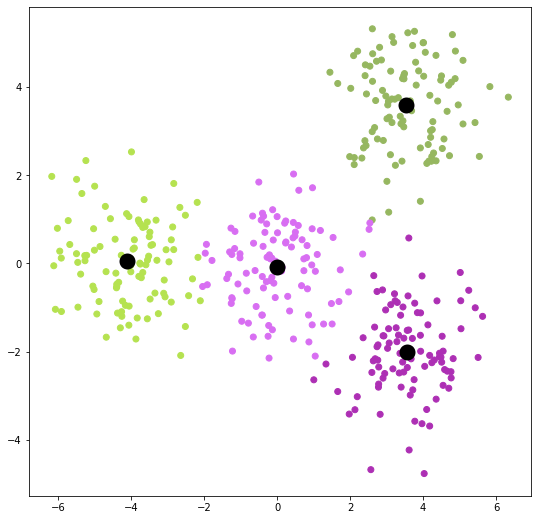

method of init = sample


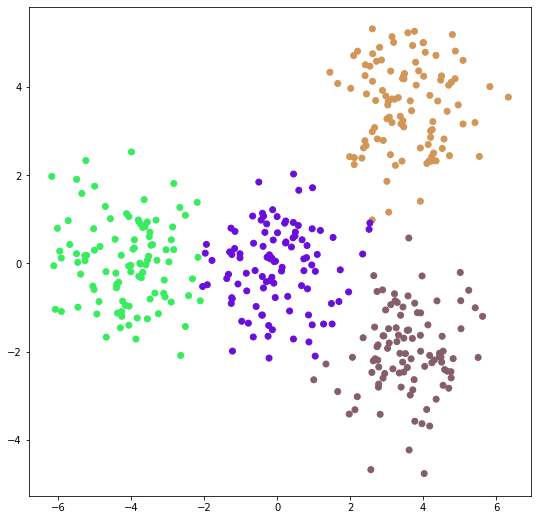

method of init = random


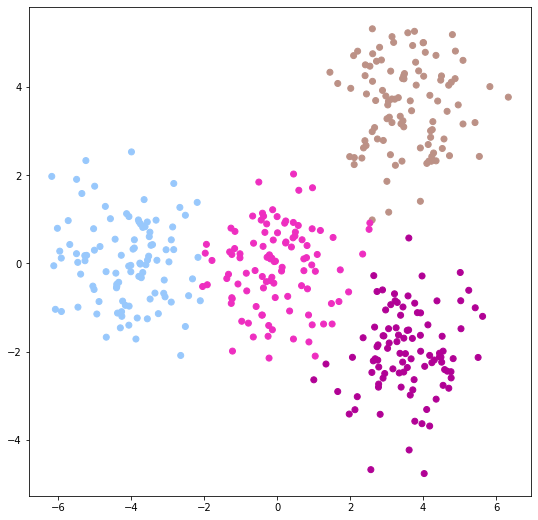

In [15]:
kmeans = KMeans(n_clusters=4, init='k-means++')
a = kmeans.fit(X_1)
print('method of init = k-means++')
print('черные точки -- центроиды')
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels, a[1].T)

kmeans = KMeans(n_clusters=4, init='sample')
kmeans.fit(X_1)
print('method of init = sample')
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=4, init='random')
kmeans.fit(X_1)
print('method of init = random')
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

method of init = k-means++


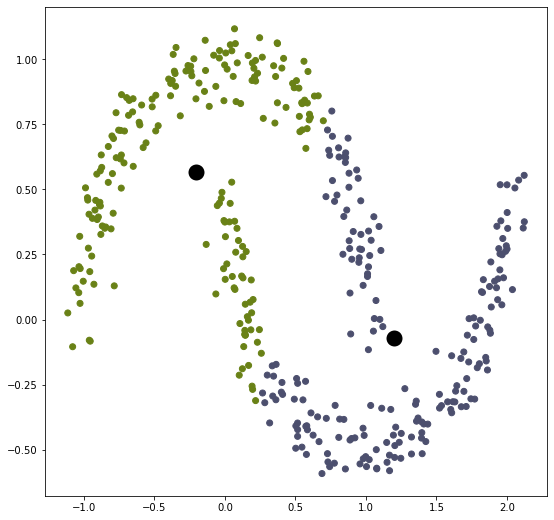

method of init = sample


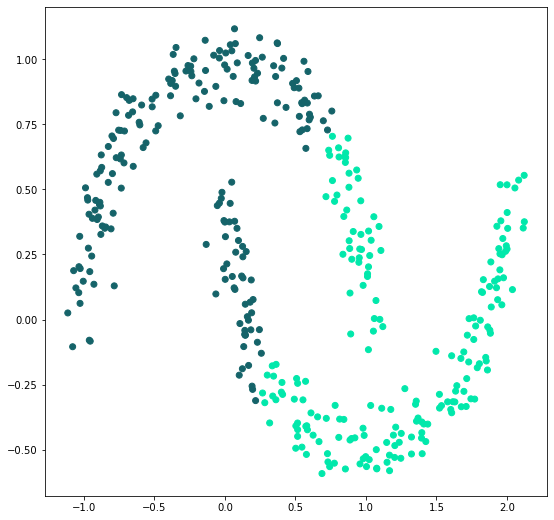

method of init = random


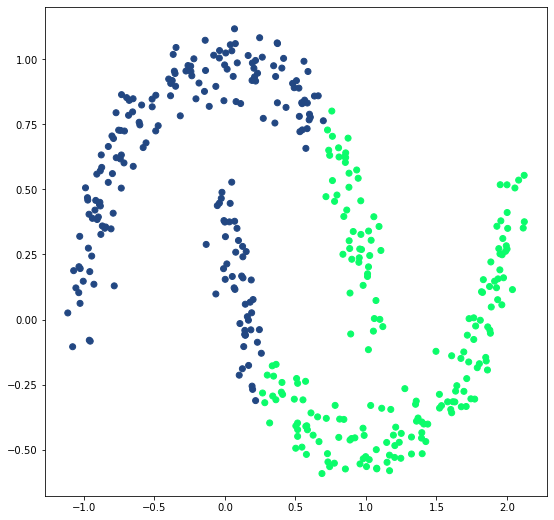

In [16]:
kmeans = KMeans(n_clusters=2, init='k-means++')
a = kmeans.fit(X_2)
print('method of init = k-means++')
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels, a[1].T)

kmeans = KMeans(n_clusters=2, init='sample')
kmeans.fit(X_2)
print('method of init = sample')
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

kmeans = KMeans(n_clusters=2, init='random')
kmeans.fit(X_2)
print('method of init = random')
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### 2. DBScan (3.5 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

__Описание методов__

`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

__Возможные метрики__

* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [57]:
class DBScan:
    def __init__(self, eps=0.5, min_samples=5, leaf_size=40, metric="euclidean"):
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric
        self.tree = None
    
    def fit_predict(self, X, y=None):
        
        # реализуем функцию для рекурсивного поиска ближайших соседей данной точки
        def find(x, i):
            n_neighboard = self.tree.query_radius(self.data, r=self.eps, count_only=True)[i]

            if self.labels[i] == 0 and n_neighboard > self.min_samples:
                self.labels[i] = self.count_cluster
                neighboard = self.tree.query_radius(self.data, r=self.eps)[i]

                for idx in neighboard:
                    find(self.data[idx], idx)
                
        self.tree = KDTree(X, leaf_size=self.leaf_size, metric=self.metric)
        self.labels = [0] * len(X)
        self.count_cluster = 1
        self.data = X
        
        for i, x in enumerate(X):
            n_neighboard = self.tree.query_radius(X, r=self.eps, count_only=True)[i]
            
            if n_neighboard > self.min_samples and self.labels[i] == 0:
                self.count_cluster += 1
                find(x, i)
            elif 0 < n_neighboard and n_neighboard <= self.min_samples and self.labels[i] == 0:
                self.labels[i] = 1
            elif n_neighboard == 0:
                self.labels[i] = 0
        
        for i, x in enumerate(X):
            if self.labels[i] == 1:
                neighboard = self.tree.query_radius(X, r=self.eps)[i]
                targ = Counter([self.labels[index] for index in neighboard]).most_common(2)[0][0]
                
                if targ == 1 and len(Counter([self.labels[index] for index in neighboard]).most_common(2)) > 1:
                    targ = Counter([self.labels[index] for index in neighboard]).most_common(2)[1][0]
                self.labels[i] = targ
                
        return self.labels

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

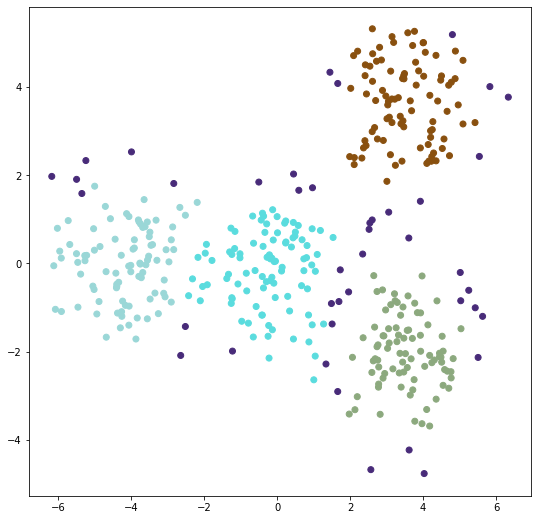

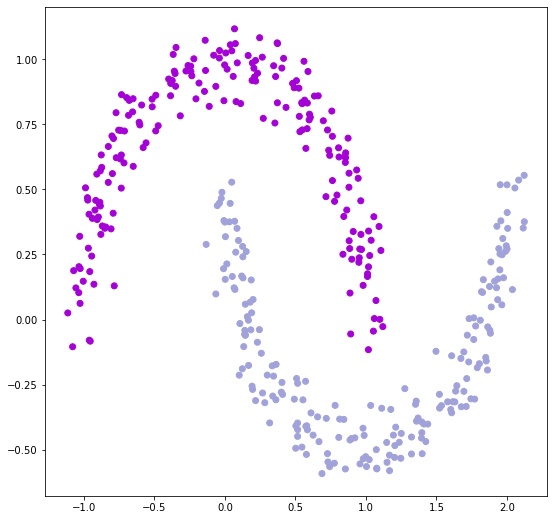

In [58]:
dbscan = DBScan(eps=0.62, min_samples=6)
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(eps=0.19, min_samples=4)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### 3. Оценка качества моделей (1 балл)
Проанализируйте полученные результаты. 

Какой метод лучше справился с кластеризацией? Почему? 

Сравните значения метрик  `Davies-Bouldin index` и `Silhouette score` для определения качества кластеризации. 

Какие значения метрики свидетельствуют о хорошей кластеризации - большие или маленькие?

Маленькие значения для Davies-Bouldin index и большие для Silhouette score -- хорошая кластеризация. 

In [33]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

In [49]:
kmeans1 = KMeans(n_clusters=4, init='k-means++')
kmeans2 = KMeans(n_clusters=2, init='k-means++')
dbscan1 = DBScan(eps = 0.62, min_samples=6)
dbscan2 = DBScan(eps = 0.19, min_samples=4)
db1 = dbscan1.fit_predict(X_1)
db2 = dbscan2.fit_predict(X_2)
kmeans1.fit(X_1)
kmeans2.fit(X_2)
res1 = np.column_stack((X_1, true_labels1))
res2 = np.column_stack((X_2, true_labels2))

```Davies-Bouldin index```  определяется как функция отношения разброса внутри кластера к разделению между кластерами, поэтому чем меньше данный индекс, тем лучше произошла кластеризация

In [50]:
davies_bouldin_score(res1, np.array(kmeans1.predict(X_1)))

0.5476861876029814

In [38]:
davies_bouldin_score(res2, np.array(kmeans2.predict(X_2)))

0.9181589019378325

In [51]:
davies_bouldin_score(res1, np.array(db1))

1.4937358927040567

In [52]:
davies_bouldin_score(res2, np.array(db2))

0.9168878526120271

Видно, что для первого набора индекс меньше в случае kmeans, потому кластеризация для него произошла лучше (что видно было по графикам), в случае DBscan наоборот, что также видно из графиков.

`Silhouette score`

In [41]:
silhouette_score(res1, np.array(kmeans1.predict(X_1)))

0.6027458592130704

In [42]:
silhouette_score(res2, np.array(kmeans2.predict(X_2)))

0.4345524687715336

In [43]:
silhouette_score(res1, np.array(db1))

0.20247026703030044

In [44]:
silhouette_score(res2, np.array(db2))

0.4670484869929966

Для данной метрики высокое значение указывает на то, что объект хорошо подобран к собственному кластеру и плохо подобран к соседним кластерам, как видно, в случае DBscan метрика выше для второй выборки и ниже для первой (что видно по графикам), для kmeans наоборот, что так же видно по графикам.